In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import sys
sys.path.insert(0, "../src/")

In [212]:
import numpy as np
import pandas as pd
import xarray as xr
import yaml

# Plotting
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
import seaborn as sns
from cmocean import cm
import hvplot.xarray
import xrscipy.signal as dsp
from xarrayutils.vertical_coordinates import linear_interpolation_regrid, linear_interpolation_remap
import gsw

from niwtools.tools import *
from niwtools.qc import qc_turbulence, qc_velocity


from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
from scipy.integrate import trapz

import warnings
warnings.simplefilter("ignore")

purp = pd.read_pickle('../data/purp_colormap.pkl')
# set up figure params
sns.set(style='ticks', context='notebook',font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[12, 6])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

xr.set_options(display_style="text", display_width=100,warn_for_unclosed_files=True);

In [6]:
# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from cartopy.mpl.gridliner import LATITUDE_FORMATTER, LONGITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [244]:
def plotMap():
    #Set the projection information
    proj = ccrs.PlateCarree()
    #Create a figure with an axes object on which we will plot. Pass the projection to that axes.
    fig, ax = plt.subplots(subplot_kw=dict(projection=proj))

    #Zoom in
    img_extent = [140, 149, 34, 45]
    ax.set_extent(img_extent, crs=proj)

#     ax.set_xticks([ 141,145,148], crs=ccrs.PlateCarree())
    #Add map features
    # ax.add_feature(cfeature.LAND, facecolor='0.9'
    # )  #Grayscale colors can be set using 0 (black) to 1 (white)

    land_50m = cfeature.NaturalEarthFeature('physical',
                                            'land',
                                            '50m',
                                            edgecolor='face',
                                            facecolor=cfeature.COLORS['land'])
    ax.add_feature(land_50m)
    ax.add_feature(
        cfeature.LAKES,
        alpha=0.9)  #Alpha sets transparency (0 is transparent, 1 is solid)
    ax.add_feature(cfeature.BORDERS, zorder=10)
    # ax.add_feature(cfeature.COASTLINE, zorder=10)
    gshhs = cfeature.GSHHSFeature(scale='i', levels=None)
    ax.add_feature(gshhs)

    #We can use additional features from Natural Earth (http://www.naturalearthdata.com/features/)
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    ax.add_feature(states_provinces, edgecolor='gray', zorder=10)

    #Add lat/lon gridlines every 20° to the map
    gl = ax.gridlines(crs=ccrs.PlateCarree(),
                      draw_labels=True,
                      linewidth=0.1,
                      alpha=1,
                      linestyle='-')
    
    gl.xlabels_top = False
    gl.ylabels_left = False
#     gl.set_xticks(141)
#     gl.xlocator = mticker.FixedLocator(**[148, 0, 148]**)
    gl.xlocator = mticker.FixedLocator([141,146,151])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    ax.text(142.2, 43.5, 'Hokkaido', transform=proj)
    ax.text(140.1, 39.7, 'Honshu', transform=proj)
    
#     
#     ax.set_xticks([144,145,146, 147], crs=ccrs.PlateCarree())
#     ax.set_yticks([34, 44], crs=ccrs.PlateCarree())

    return fig, ax


def plot_weather(date, dss, float1, float2):
    fig, ax = plotMap()

    float1.plot.scatter(x='lon',y='lat', zorder=20,color='b',s=5)
    float2.plot.scatter(x='lon',y='lat',zorder=20,color='k',s=5)
    
    preslevels = np.linspace(950, 1400, 10)
    prescontour = ax.contour(dss.lon,
                             dss.lat,
                             dss.pres.T,
                             colors='k',
                             levels=preslevels,
                             linewidths=1,
                             zorder=11,
                             transform=ccrs.PlateCarree())
    plt.clabel(prescontour, preslevels, inline=True, fmt='%1i', fontsize=12)

    speedlevels = np.linspace(20, 36,num=10)
    sp = ax.contourf(dss.lon,
                     dss.lat,
                     dss.wspeed.T,
                     levels=speedlevels,
                     cmap=plt.cm.YlOrRd,
                     zorder=2,
                     transform=ccrs.PlateCarree())

    x, y = np.meshgrid(dss.lon, dss.lat, indexing='ij')
    wslice = slice(0, -1, 10)
    ax.barbs(x[wslice, wslice],
             y[wslice, wslice],
             dss.u10.values[wslice, wslice],
             dss.v10.values[wslice, wslice], 
             transform=ccrs.PlateCarree(),
             zorder=20)

    plt.colorbar(sp,
                 ax=ax,
                 ticks=np.arange(10, 36, 2),
                 label=r'Wind speed m$s^{-1}$',
                 orientation='vertical',
                 aspect=40,
                 shrink=0.87,
                 pad=0.1)
    plt.title(date)
    plt.savefig('../figures/events/A/weather_%s.pdf' %
                (date))
    fig.savefig('../figures/events/A/better_map.pdf')
    plt.show()


def weather_wrapper(infile, outfile):
    ds = xr.open_dataset(str(infile))
    # dates = pd.date_range(start='1/1/2018', end='1/08/2018', freq='6H')

    date= str(outfile).split(sep='weather_')[-1].split('.')[0]
    dss = ds.sel(time=pd.to_datetime(date,format="%d%m%y_%Hh"))
    plot_weather(date, dss)


In [245]:
with open('events.yml') as fp:
    events = yaml.full_load(fp)

In [246]:
ds

<xarray.Dataset>
Dimensions:  (lat: 98, lon: 245, time: 2548)
Coordinates:
  * lat      (lat) float32 49.982952 49.778522 49.574097 49.369667 ... 30.562176 30.357746 30.153316
  * lon      (lon) float32 130.09091 130.29546 130.5 130.70454 ... 179.59091 179.79546 180.0
  * time     (time) datetime64[ns] 2016-08-01 2016-08-01T06:00:00 ... 2018-04-29T18:00:00
Data variables:
    pres     (lon, lat, time) float64 ...
    temp     (lon, lat, time) float64 ...
    u10      (lon, lat, time) float64 ...
    v10      (lon, lat, time) float64 ...
    wspeed   (lon, lat, time) float64 ...

In [247]:
ds = xr.open_dataset('../data/CFS/CFSv2_wind_rh_t_p_2016_2018.nc')
event='A'
f1 = xr.open_dataset(f'../data/xarray/xr_7787a.nc').sel(time=slice(*events[event]['times']))
f2 = xr.open_dataset(f'../data/xarray/xr_7788a.nc').sel(time=slice(*events[event]['times']))


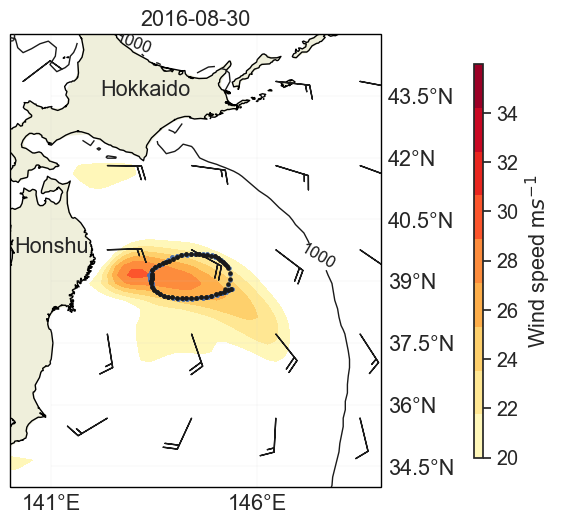

In [248]:
plot_weather('2016-08-30',ds.sel(time='2016-08-30T06:00:00'),f1,f2)